In [1]:
import pickle
import json

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
def cumulativeGoodCandidates(ranking):
    cumulative = []
    n_good_candidates = 0
    
    for index, ranked_user in ranking.iterrows():
        if ranked_user['good'] == True:
            n_good_candidates = n_good_candidates + 1
        cumulative.append(n_good_candidates)
    result = np.array(cumulative)
    n = result.shape[0]
    
    # list of aw is only with top20 and some random is missing in the network, resulting
    # in a list smaller than 20: add the last value to reach 20 (missings
    # are only negative candidates)
    if n < 20:
        result = np.append(result, [result[n-1]]*(20-n))
        
    return result 

In [3]:
def averageRankPos(ranking, avg_rank):
    for index, candidate in ranking.iterrows():
        username = candidate[0]
        try:
            avg_rank[username].append(index+1)
        except:
            # initialization
            avg_rank[username] = [index+1]

In [4]:
allseeds = list(map(str, pd.read_csv('../data-seed/aw/user.csv', sep='\t')['screen_name']))
combinations = json.load(open('combinations.json', 'rb'))

In [5]:
content_ranking = pickle.load(open('../../fingerprints/aw_best20_vocabulary.pkl' , 'rb'))
context_ranking = json.load(open('aw_ranking_cosine.json', 'rb'))
# agg_ranking = json.load(open('finance_ranking_agg_median.json', 'rb'))

In [10]:
avg_r_ct = {}
avg_r_cx = {}
avg_r_agg = {}
avg_r_borda = {}

ensemble_p10 = 0
borda_p10 = 0

ysum_agg = 0
ysum_borda = 0
ysum_content = 0
ysum_context = 0
for i in range(50):
    good_candidates = set(set(allseeds)-(set(combinations[str(i)])))
    
    context_r = pd.DataFrame(context_ranking[str(i)])
    content_r = pd.DataFrame(content_ranking[i])
    # agg_r = pd.DataFrame(agg_ranking[str(i)])
    
    context_r['good'] = context_r.apply(lambda x: True if x[0] in good_candidates else False, axis=1)
    content_r['good'] = content_r.apply(lambda x: True if x[0] in good_candidates else False, axis=1)
    # agg_r['good'] = agg_r.apply(lambda x: True if x[0] in good_candidates else False, axis=1)
    
    borda_r = content_r.reset_index().merge(context_r.reset_index(), on=0, how='inner')#.fillna(0)
    borda_r['ranking'] = borda_r.apply(lambda x: x['index_x']+x['index_y'], axis=1)
    borda_r = borda_r.sort_values(by='ranking', ascending=True)
    borda_r['good'] = borda_r.apply(lambda x: True if x[0] in good_candidates else False, axis=1)
    
    averageRankPos(context_r, avg_r_cx)
    averageRankPos(content_r, avg_r_ct)
    # averageRankPos(agg_r, avg_r_agg)
    averageRankPos(borda_r, avg_r_borda)
            
    # y_agg = cumulativeGoodCandidates(agg_r)
    y_borda = cumulativeGoodCandidates(borda_r)
    y_content = cumulativeGoodCandidates(content_r)
    y_context = cumulativeGoodCandidates(context_r)
    
    # ysum_agg += y_agg
    ysum_borda += y_borda
    ysum_content += y_content
    ysum_context += y_context
    
    # ensemble_p10 += y_agg[9]
    borda_p10 += y_borda[9]
    
# print ('P@10 ensembled:', ensemble_p10/50)
print ('P@10 Borda:', borda_p10/50)

P@10 Borda: 5.38


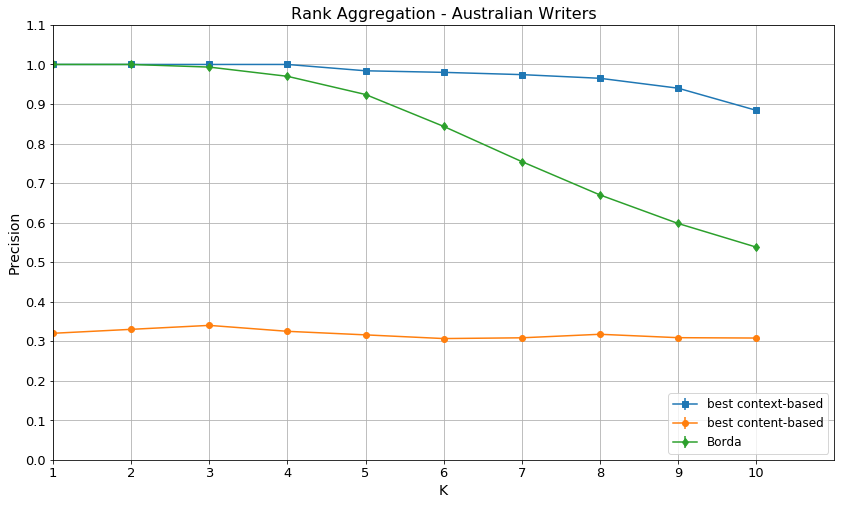

In [11]:
# ensemble = ysum_agg.astype(float)/50
borda = ysum_borda.astype(float)/50
best_content = ysum_content.astype(float)/50
best_context = ysum_context.astype(float)/50


plt.figure(figsize=(14,8))

K = 10
x = range(K)

prec_cx = [best_context[i-1]/i for i in range(1, K+1)]
plt.errorbar(x, prec_cx, yerr=[0.]*K, label='best context-based', fmt='s', ls='-') # std_men[:K].reshape(-1,1)

prec_ct = [best_content[i-1]/i for i in range(1, K+1)]
plt.errorbar(x, prec_ct, yerr=[0.]*K, label='best content-based', fmt='o', ls='-') # std_1[:K]

# prec_e = [ensemble[i-1]/i for i in range(1, K+1)]
# plt.errorbar(x, prec_e, yerr=[0.]*K, label='ensembled', fmt='^', ls='-') # std_2[:K]

prec_b = [borda[i-1]/i for i in range(1, K+1)]
plt.errorbar(x, prec_b, yerr=[0.]*K, label='Borda', fmt='d', ls='-') # std_3[:K]


plt.legend(loc=4, fontsize='large')
plt.title('Rank Aggregation - Australian Writers', fontsize=16)
plt.ylabel('Precision', fontsize=14)
plt.xlabel('K', fontsize=14)

plt.xlim(xmin=1, xmax=K)
plt.ylim(ymin=0, ymax=1.1)
plt.yticks(np.arange(0, 1.2, 0.1))
plt.xticks(range(0, K, int(K/10)), [str(i+1) for i in range(K)])
plt.tick_params(labelsize=13)

plt.grid(True)

### Content average ranking

In [21]:
res = []
for u in avg_r_ct:
    res.append(tuple((u, np.mean(avg_r_ct[u]))))

In [26]:
content_df = pd.DataFrame(res, columns=['username', 'average_ranking']).sort_values(by='average_ranking')
content_df['community'] = content_df['username'].apply(lambda x: True if x in allseeds else False)
content_df[:20]

,username,average_ranking,community
0,economistmeg,1.384615,True
1,dsquareddigest,2.384615,True
97,firoozye,3.450000,True
96,faulljonathan,3.620690,True
105,queen_europe,3.857143,True
3,rencapman,4.590909,True
2,adam,4.700000,False
99,ezraklein,5.625000,True
5,lamonicabuzz,6.291667,True
102,katie_martin_fx,6.692308,True


### Context average ranking

In [27]:
res = []
for u in avg_r_cx:
    res.append(tuple((u, np.mean(avg_r_cx[u]))))

In [ ]:
context_df = pd.DataFrame(res, columns=['username', 'average_ranking']).sort_values(by='average_ranking')
context_df['community'] = context_df['username'].apply(lambda x: True if x in allseeds else False)
context_df[:20]

Comparison content and context ranking

In [35]:
compare = context_df[context_df['community'] == True].merge(content_df[content_df['community'] == True], on='username')
compare = compare.drop(['community_x', 'community_y'], axis=1)
compare.columns = ['username', 'rank_context', 'rank_content']
compare

,username,rank_context,rank_content
0,economistmeg,1.384615,1.384615
1,reinman_mt,2.000000,46.300000
2,rencapman,3.818182,4.590909
3,economisthulk,3.842105,90.684211
4,katie_martin_fx,4.884615,6.692308
5,faulljonathan,5.103448,3.620690
6,fgoria,6.333333,8.238095
7,queen_europe,6.571429,3.857143
8,justinwolfers,6.766667,12.166667
9,laurenlacapra,8.454545,9.136364


### Aggregate average ranking

In [29]:
res = []
for u in avg_r_agg:
    res.append(tuple((u, np.mean(avg_r_agg[u]))))

In [30]:
agg_df = pd.DataFrame(res, columns=['username', 'average_ranking']).sort_values(by='average_ranking')
agg_df['community'] = agg_df['username'].apply(lambda x: True if x in allseeds else False)
agg_df[:20]

,username,average_ranking,community
0,economistmeg,1.000000,True
1,rencapman,2.500000,True
3,guzzishoes,2.660000,False
96,faulljonathan,3.068966,True
125,queen_europe,3.607143,True
116,katie_martin_fx,4.576923,True
2,fgoria,4.761905,True
100,ezraklein,7.125000,True
6,laurenlacapra,7.136364,True
4,justinwolfers,7.833333,True
